This example will show how to use an equivariant UNet to learn the gradient of a scalar field discretized to an image. The input will be a scalar image, the output will be a vector image, and the intermediate multi images will have both scalar and vector images. This will necessitate scalar, vector, and 2-tensor filters to map between the intermediate multi images. We start by specifying what GPUs to use, and importing packages.

In [16]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

import matplotlib.pyplot as plt
from typing import Any, Optional, Self, Union

import jax
import jax.numpy as jnp
import jax.random as random
from jaxtyping import ArrayLike
import equinox as eqx
import optax

import geometricconvolutions.geometric as geom
import geometricconvolutions.ml as ml
import geometricconvolutions.models as models

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


Next we generate our data. Any input scalar field will suffice, but to make them look nice and easily calculate the derivatives, we will use 3rd degree polynomials. We will calculate the scalar field in the box [-1.5,1.5] for both x and y coordinates, and discretize the field onto a 32 by 32 pixel image. The polynomial coefficients will be sampled from a normal distribution with mean 0 and standard deviation 0.4. We calculate the gradient of the polynomial exactly, then do the same discretization to get the gradient image. After finding the gradient image, we remove two rows and columns of pixels from each side to get a 28 by 28 image because calculating the gradient from only scalar image requires knowledge of the surrounding pixels.

In [17]:
def gen_scalar_gradient_imgs(
    N: int, 
    border_pixels: int,
    coeffs: jax.Array, 
    x_lims: tuple[float, float], 
    y_lims: tuple[float, float], 
) -> tuple[jax.Array, jax.Array]:
    # Dimension D=2
    x, y = jnp.meshgrid(jnp.linspace(*x_lims, N), jnp.linspace(*y_lims, N), indexing="ij")
    ones = jnp.ones(x.shape)
    x2 = x**2
    xy = x * y
    y2 = y**2
    x3 = x**3
    x2y = (x**2) * y
    xy2 = x * (y**2)
    y3 = y**3

    # library is [1, x, y, x^2, xy, y^2, x^3, x^2y, xy^2, y^3]
    library = jnp.stack([ones, x, y, x2, xy, y2, x3, x2y, xy2, y3])

    scalar_img = jnp.sum((coeffs * library), axis=0)
    assert scalar_img.shape == (N, N)

    # dx is [0, 1, 0, 2x, y, 0, 3x2, 2xy, y2, 0]
    # dy is [0, 0, 1, 0, x, 2y, 0, x2, x 2y, 3y2]
    zeros = jnp.zeros(x.shape)
    dx_library = jnp.stack([zeros, ones, zeros, 2 * x, y, zeros, 3 * x2, 2 * xy, y2, zeros])
    dy_library = jnp.stack([zeros, zeros, ones, zeros, x, 2 * y, zeros, x2, 2 * xy, 3 * y2])

    dx_sum = jnp.sum((coeffs * dx_library), axis=0)
    dy_sum = jnp.sum((coeffs * dy_library), axis=0)
    gradient_img = jnp.stack([dx_sum, dy_sum], axis=2)[border_pixels:-border_pixels,border_pixels:-border_pixels]
    assert gradient_img.shape == (N-(border_pixels*2), N-(border_pixels*2), 2)

    return scalar_img, gradient_img

def gen_images_batch(
    n_images: int,
    N: int, 
    border_pixels: int,
    x_lims: tuple[float, float], 
    y_lims: tuple[float, float], 
    coeffs_mean_std: tuple[float, float],
    key: Any, 
):
    vmap_gen_images = jax.vmap(gen_scalar_gradient_imgs, in_axes=(None, None, 0, None, None))
    coeffs = random.normal(key, shape=(n_images, 10, 1, 1)) * coeffs_mean_std[1] + coeffs_mean_std[0]
    return vmap_gen_images(N, border_pixels, coeffs, x_lims, y_lims)

def gen_data(
    N: int, 
    border_pixels: int,
    n_train: int, 
    n_val: int,
    n_test: int,
    x_lims: tuple[float, float],
    y_lims: tuple[float, float],
    coeffs_mean_std: tuple[float, float],
    key: ArrayLike,
    normalize: bool = True,
) -> tuple[
    geom.BatchMultiImage, 
    geom.BatchMultiImage, 
    geom.BatchMultiImage, 
    geom.BatchMultiImage, 
    geom.BatchMultiImage, 
    geom.BatchMultiImage,
]:
    key, subkey1, subkey2, subkey3 = random.split(key, num=4)
    train_x, train_y = gen_images_batch(n_train, N, border_pixels, x_lims, y_lims, coeffs_mean_std, subkey1)
    val_x, val_y = gen_images_batch(n_val, N, border_pixels, x_lims, y_lims, coeffs_mean_std, subkey2)
    test_x, test_y = gen_images_batch(n_test, N, border_pixels, x_lims, y_lims, coeffs_mean_std, subkey3)

    if normalize:
        scalar_mean = jnp.mean(jnp.concatenate([train_x, val_x]))
        scalar_std = jnp.std(jnp.concatenate([train_x, val_x]))

        train_x = (train_x - scalar_mean) / scalar_std
        val_x = (val_x - scalar_mean) / scalar_std
        test_x = (test_x - scalar_mean) / scalar_std

        grad_std = jnp.std(jnp.concatenate([train_y, val_y]))

        train_y = train_y / grad_std
        val_y = val_y / grad_std
        test_y = test_y / grad_std

    return (
        geom.BatchMultiImage({(0, 0): jnp.expand_dims(train_x, axis=1)}, 2, is_torus=False),
        geom.BatchMultiImage({(1, 0): jnp.expand_dims(train_y, axis=1)}, 2, is_torus=False),
        geom.BatchMultiImage({(0, 0): jnp.expand_dims(val_x, axis=1)}, 2, is_torus=False),
        geom.BatchMultiImage({(1, 0): jnp.expand_dims(val_y, axis=1)}, 2, is_torus=False),
        geom.BatchMultiImage({(0, 0): jnp.expand_dims(test_x, axis=1)}, 2, is_torus=False),
        geom.BatchMultiImage({(1, 0): jnp.expand_dims(test_y, axis=1)}, 2, is_torus=False),
    )

# data params
D = 2 # image dimension
N = 32 # image side length
border_pixels = 2
n_train = 128 
n_val = 32
n_test = 128
domain_lims = (-1.5, 1.5)
coeff_mean_std = (0, 0.4)

key = random.PRNGKey(0)
key, subkey = random.split(key)
train_x, train_y, val_x, val_y, test_x, test_y = gen_data(
    N, 
    border_pixels, 
    n_train,
    n_val,
    n_test,
    domain_lims, 
    domain_lims, 
    coeff_mean_std,
    subkey,
)
print(train_x)
print(train_y)

<class 'geometricconvolutions.geometric.multi_image.BatchMultiImage'> D: 2, is_torus: (False, False)
	(0, 0): (128, 1, 32, 32)

<class 'geometricconvolutions.geometric.multi_image.BatchMultiImage'> D: 2, is_torus: (False, False)
	(1, 0): (128, 1, 28, 28, 2)



Lets take a look at an image to see if they look correct.

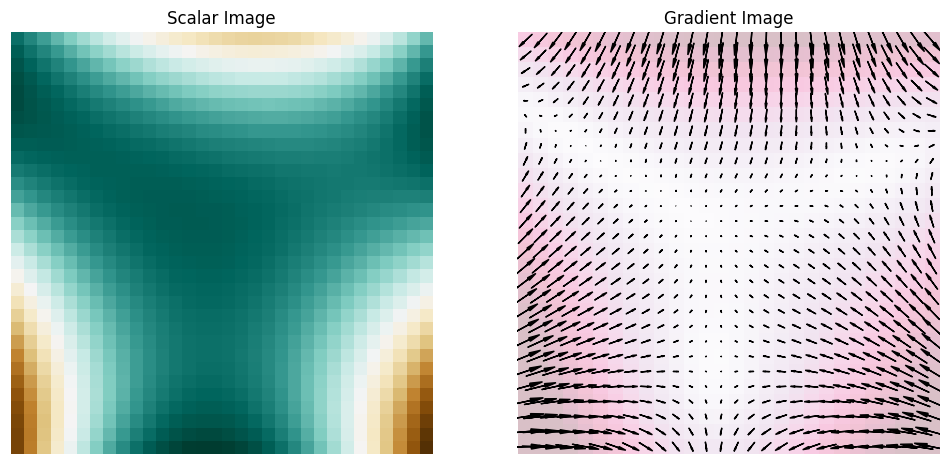

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6 * 2, 6 * 1))
train_x.get_one_batch_multi_image().to_images()[0].plot(axes[0], 'Scalar Image')
train_y.get_one_batch_multi_image().to_images()[0].plot(axes[1], 'Gradient Image')

Next we define our `map_and_loss` function. To use our training scripts, this must take 4 arguments: the model, the input multi image, the output target multi image, and aux data that would be used by layers like BatchNorm. Likewise, it must return the loss and the aux data. We use the sum of mean squared error loss which takes the sum over the tensor and channel indices, and the mean over the spatial dimensions and batch.

In [19]:
def map_and_loss(
    model: eqx.Module,
    multi_image_x: geom.BatchMultiImage,
    multi_image_y: geom.BatchMultiImage,
    aux_data: Optional[eqx.nn.State] = None,
) -> tuple[jax.Array, Optional[eqx.nn.State]]:
    assert callable(model)
    pred_y = model(multi_image_x)
    return ml.smse_loss(pred_y, multi_image_y), aux_data

Next, we define our model. We will use an equivariant UNet defined in geometricconvolutions.models. It requires the invariant basis of filters for downsampling and upsampling. We will specify 2 downsampling blocks, with 2 convolutions per block with 32 channels each. This model is more than enough firepower for this simple problem. Again, the input is a scalar image, the output image is a vector image, and the intermediate multi images will have both scalar images and vectors iamges. We modify the UNet slightly by reducing the output image by 2 rows and columns from each side (controlled by the `border_pixels` parameter).

In [20]:
class ModifiedUNet(eqx.Module):
    _unet: models.UNet
    b: int

    def __init__(self: Self, border_pixels: int, unet: models.UNet):
        self._unet = unet
        self.b = border_pixels

    def __call__(self: Self, x: geom.BatchMultiImage):
        unet_out = self._unet(x)
        assert isinstance(unet_out, geom.BatchMultiImage)
        out = unet_out.empty()
        for (k, parity), image in unet_out.items():
            out.append(k, parity, image[:,:,self.b:-self.b,self.b:-self.b])

        return out


operators = geom.make_all_operators(D)
conv_filters = geom.get_invariant_filters([3], [0,1,2], [0,1], D, operators)
upsample_filters = geom.get_invariant_filters([2], [0,1,2], [0,1], D, operators)

key, subkey = random.split(key)
model = ModifiedUNet(
    border_pixels,
    models.UNet(
        D, 
        train_x.get_signature(), 
        train_y.get_signature(), 
        depth=32, 
        num_downsamples=2, 
        num_conv=2, 
        use_bias='auto', 
        activation_f=jax.nn.gelu, 
        equivariant=True, 
        conv_filters=conv_filters, 
        upsample_filters=upsample_filters,
        key=subkey,
    ),
)

Finally, we specify our training hyper-parameters and call our training loop. The epochs, batch size, learning rate, and optimizer could likely be further tuned, but the choices below are sufficient for this simple problem.

In [21]:
# training_params
epochs = 10
batch_size = 10
lr = 1e-3

key, subkey = random.split(key)
trained_model, _, train_loss, val_loss = ml.train(
    train_x, 
    train_y, 
    map_and_loss, 
    model, 
    subkey, 
    ml.EpochStop(epochs, verbose=1), 
    batch_size, 
    optax.adamw(lr),
    val_x,
    val_y,
)

key, subkey = random.split(key)
print('train_loss:', train_loss)
print('val_loss:', val_loss)


Epoch 1 Train: 1.2856472 Val: 0.1195528 Epoch time: 19.89652
Epoch 2 Train: 0.0480993 Val: 0.0111710 Epoch time: 3.97370
Epoch 3 Train: 0.0078394 Val: 0.0041695 Epoch time: 3.71187
Epoch 4 Train: 0.0031028 Val: 0.0021831 Epoch time: 3.44136
Epoch 5 Train: 0.0019382 Val: 0.0014608 Epoch time: 3.61967
Epoch 6 Train: 0.0012450 Val: 0.0011570 Epoch time: 3.90623
Epoch 7 Train: 0.0010001 Val: 0.0010510 Epoch time: 3.98744
Epoch 8 Train: 0.0008929 Val: 0.0009250 Epoch time: 4.04969
Epoch 9 Train: 0.0007502 Val: 0.0007076 Epoch time: 4.07114
Epoch 10 Train: 0.0006239 Val: 0.0007091 Epoch time: 4.02620
train_loss: 0.00062390906
val_loss: 0.00070908293


Lets see how the model performs on one example from the training set.

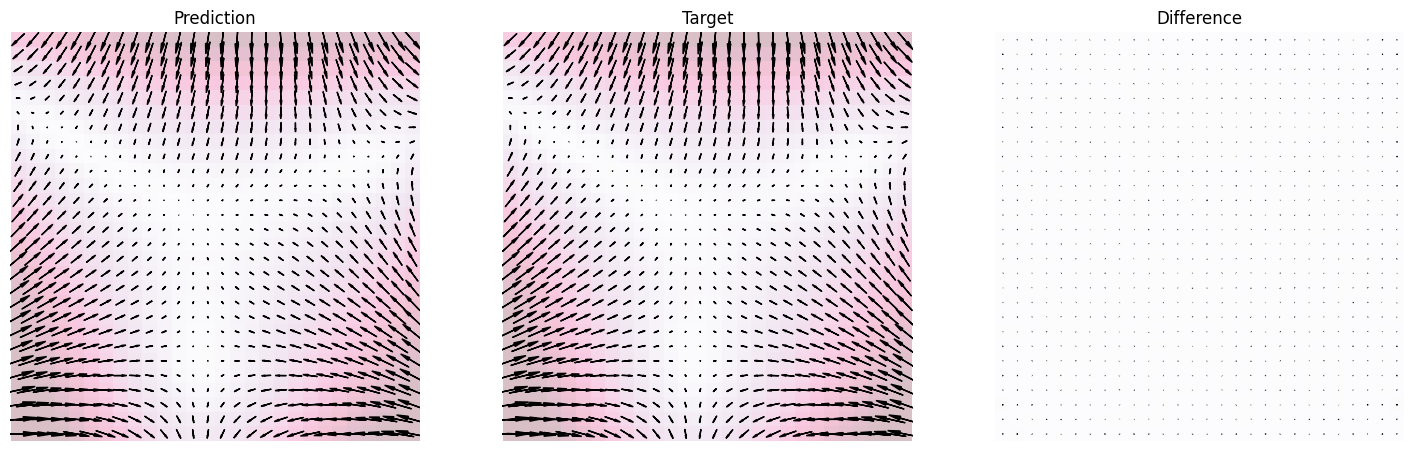

In [22]:
pred_y = trained_model(train_x.get_one()).get_one_batch_multi_image().to_images()[0]
y_img = train_y.get_one_batch_multi_image().to_images()[0]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6 * 3, 6 * 1))
pred_y.plot(axes[0], 'Prediction')
y_img.plot(axes[1], 'Target')
(pred_y - y_img).plot(axes[2], 'Difference')



Finally, we would like to know how the model performs on a test data set. We print the average test error, as well as one example.

test_loss: 0.00063573977
0.00064172235


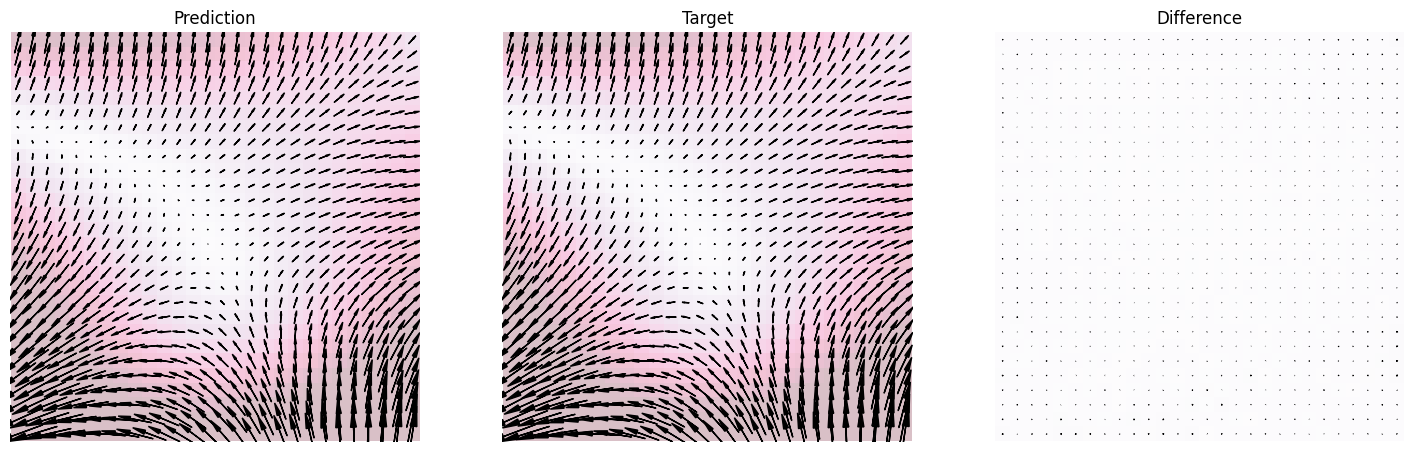

In [23]:
key, subkey = random.split(key)

print('test_loss:', ml.map_loss_in_batches(map_and_loss, trained_model, test_x, test_y, batch_size, subkey))

pred_y = trained_model(test_x.get_one()).get_one_batch_multi_image().to_images()[0]
y_img = test_y.get_one_batch_multi_image().to_images()[0]

print(map_and_loss(trained_model, test_x.get_one(), test_y.get_one(), None)[0])
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6 * 3, 6 * 1))
(pred_y).plot(axes[0], 'Prediction')
(y_img).plot(axes[1], 'Target')
(pred_y - y_img).plot(axes[2], 'Difference')

A further interesting experiment would be to see how the model performs on data which looks very different, for example different domains, different coefficient sampling schemes or even different equations. Try it out!